<a href="https://colab.research.google.com/github/snymanje/MultiClass-Text-Classification-Unsupervised/blob/master/Unsupervised_Text_Clustering_with_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## We will be using K-Means to group consumer complaints.

So what exactly is K-means? Well, it is an unsupervised learning algorithm (meaning there are no target labels) that allows you to identify similar groups or clusters of data points within your data. 

In this example we do have the labels but we will only us it to see how we the model performed.

## Import and munipulate the data 

In [180]:
import pandas as pd
import numpy as np

# Import the Consumer Complaints dataset 
dataset = pd.read_csv('drive/My Drive/Colab Notebooks/Consumer_Complaints.csv')

# Only select the Product and Consumer complaint columns
col = ['Product', 'Consumer Complaint']
dataset= dataset[col]

# Drop rows with missing labels
dataset.dropna(subset=["Consumer Complaint"], inplace=True)

# Rename the Consumer Complaint column to ConsumerComplaint
dataset.columns=['Product', 'ConsumerComplaint']

# Select only only these products
dataset=dataset[dataset['Product'].isin(['Credit reporting', 'Debt collection', 'Mortgage', 'Credit card','Student loan','Bank account or service','Consumer Loan'])]

# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
dataset = dataset.sample(frac=1)
dataset.head(10)

,Product,ConsumerComplaint
8971,Student loan,"I have XXXX loans with Navient, XXXX stafford ..."
1858,Credit reporting,I disputed information on my credit report to ...
8511,Mortgage,I received a letter from Ocwen stating that ho...
9331,Student loan,I always make my monthly payment online from n...
763,Credit reporting,"Hello, I have been a victim of Identity theft ..."
9945,Debt collection,For 1-1/2 yrs ( est. ) Dyck O'Neal Inc.- a deb...
2085,Credit reporting,"After a divorce, I was granted Innocent Spouse..."
7699,Debt collection,I 've sent multiple letters to this agency abo...
4272,Debt collection,"I went with another cell carrier in XXXX, 2016..."
7647,Credit reporting,"equifax is report a acct that on XX/XX/2016, o..."


## Plot the data

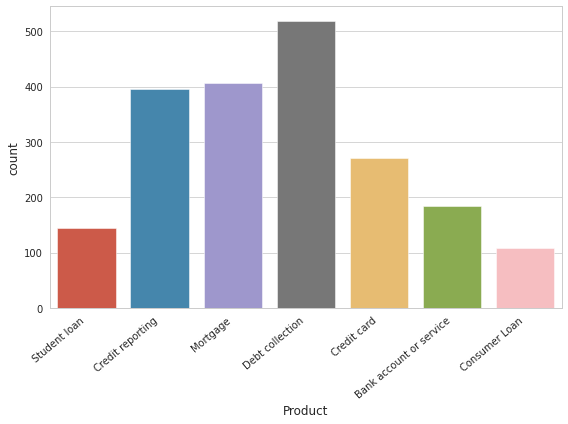

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Product', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

## Clean the data

We need to remove stop words, numbers, unnecessary white space or any other characters that can badly effect the outcome.

And lastly we will stem the data

In [182]:
# What does the data look like now?
dataset["ConsumerComplaint"]

8971    I have XXXX loans with Navient, XXXX stafford ...
1858    I disputed information on my credit report to ...
8511    I received a letter from Ocwen stating that ho...
9331    I always make my monthly payment online from n...
763     Hello, I have been a victim of Identity theft ...
                              ...                        
3622    Wron report about us, my wife and me. \nHi, my...
4901    DESIGNED RECEIVABLE SOLUTIONS has placed a der...
8650    Virtually since this loan 's inception about s...
8580    My mother passed away in 2013, leaving her hom...
6733    My home has been stolen by Wells Fargo Bank N....
Name: ConsumerComplaint, Length: 2029, dtype: object

From the above we can see that we need to convert everything to lowercase, and remove numbers and thinks like \n

Let's create a function to do most of this.

In [183]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [184]:
dataset["ConsumerComplaint"] = dataset["ConsumerComplaint"].apply(clean_text)
dataset["ConsumerComplaint"]

8971    loan navient stafford privat stafford loan wen...
1858    disput inform credit report credit bureau also...
8511    receiv letter ocwen state home equiti line mat...
9331    alway make monthli payment onlin navientcom tr...
763     hello victim ident theft multipl occas sinc re...
                              ...                        
3622    wron report us wife hi name wife wife chang ca...
4901    design receiv solut place derogatori account c...
8650    virtual sinc loan incept si month ago lender l...
8580    mother pass away leav home famili eecutor esta...
6733    home stolen well fargo bank na fraudul use law...
Name: ConsumerComplaint, Length: 2029, dtype: object

This looks much better!

## Run TF IDF Vectorizer on the text data

Convert text features to numeric
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives

In [185]:
# Run TF IDF Vectorizer on the text data

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features
vectorizer = TfidfVectorizer(sublinear_tf= True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')
X_train_vc = vectorizer.fit_transform(dataset["ConsumerComplaint"])

pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names()).head()

,abil,abl,abl help,abl make,abl pay,abl reach,absolut,abus,accept,access,access account,accord,accordingli,account,account account,account advis,account ask,account balanc,account bank,account charg,account check,account close,account collect,account compani,account contact,account credit,account current,account day,account debt,account delet,account disput,account file,account howev,account includ,account inform,account late,account list,account manag,account neg,account nt,...,whatev,whatsoev,wife,wire,wish,wit,withdraw,withdrawn,withdrew,wo,wo nt,woman,wonder,word,work,work compani,work hard,worri,wors,worst,worth,write,written,wrong,wrong address,wrong inform,wrote,ye,year,year ago,year later,year loan,year old,year pay,year year,yesterday,york,young,yr,zero
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075315,0.0,0.155419,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.127735,0.108112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.068040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.152028,0.0,0.147225,0.0,0.0,0.175471,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.098207,0.0,0.106868,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.030907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.093996,0.0,0.0,0.0,0.067999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066415,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.094557,0.000000,0.0,0.0,0.0,0.061045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042304,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.057886,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Elbow method to select number of clusters

This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified. Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

### Basically, number of clusters = the x-axis value of the point that is the corner of the "elbow"(the plot looks often looks like an elbow)

In [0]:
k_clusters = 10

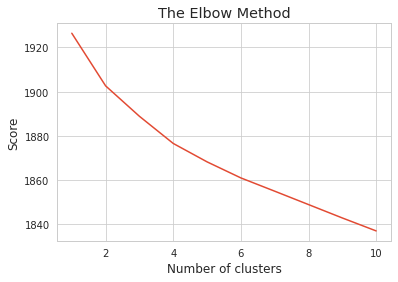

In [187]:
from sklearn.cluster import KMeans

score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    kmeans.fit(X_train_vc)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('elbow.png')
plt.show()

## Train the model to find 6 clusters

We will use 6 cluster because we already know we have 6 categories, but normally you wont know this.

In [188]:
k_clusters = 7

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(X_train_vc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=1e-06, verbose=0)

## Do some predictions and display the results

In [0]:
# First: for every document we get its corresponding cluster
clusters = model.predict(X_train_vc)

In [190]:
dataset["ClusterName"] = clusters
# Convert the label (Product) to numeric using the pd factorize function 
dataset['category_id'] = dataset['Product'].factorize()[0]
dataset.head(20)

,Product,ConsumerComplaint,ClusterName,category_id
8971,Student loan,loan navient stafford privat stafford loan wen...,0,0
1858,Credit reporting,disput inform credit report credit bureau also...,3,1
8511,Mortgage,receiv letter ocwen state home equiti line mat...,6,2
9331,Student loan,alway make monthli payment onlin navientcom tr...,0,0
763,Credit reporting,hello victim ident theft multipl occas sinc re...,3,1
9945,Debt collection,yr est dyck oneal inc debt collector tea addre...,5,3
2085,Credit reporting,divorc grant innoc spous statu ir separ ehusba...,3,1
7699,Debt collection,sent multipl letter agenc account advis identi...,3,3
4272,Debt collection,went anoth cell carrier receiv invoic pay amou...,5,3
7647,Credit reporting,equifa report acct dont live,4,1


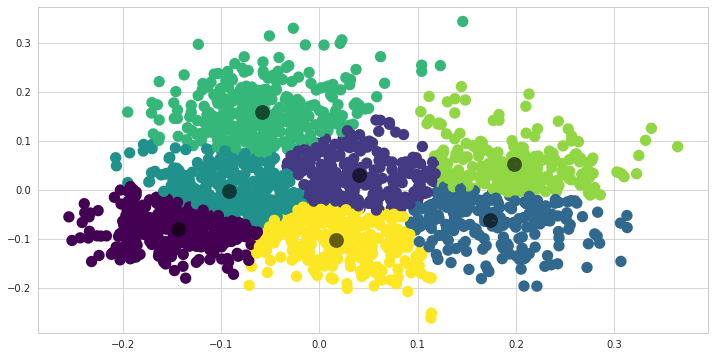

In [195]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_train_vc.toarray())
kmeans = KMeans(n_clusters=k_clusters, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

## Top terms per cluster

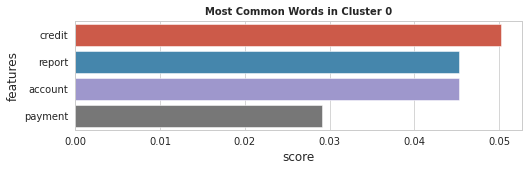

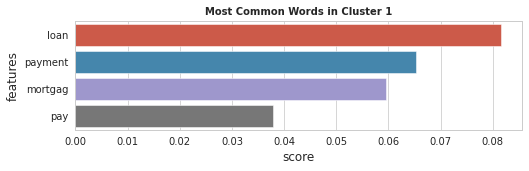

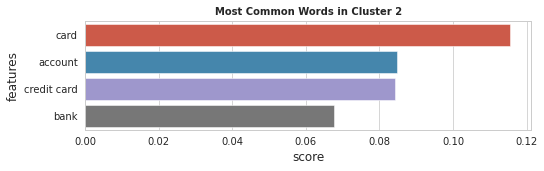

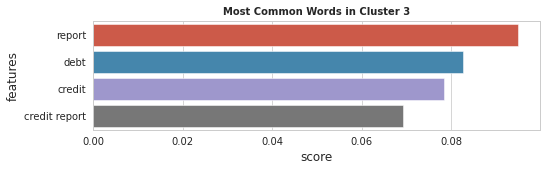

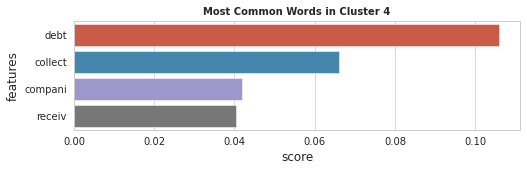

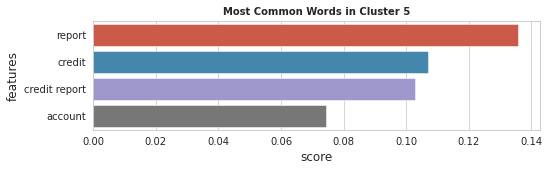

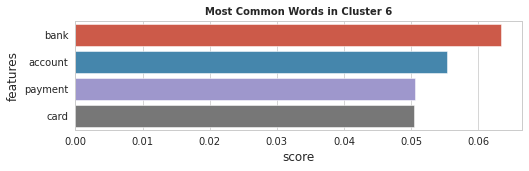

In [192]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), prediction, 4)
plotWords(dfs, 13)


In [193]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(k_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :k_clusters]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Cluster 0: payment loan pay month make late year
Cluster 1: card credit card credit charg use account balanc
Cluster 2: account bank check money deposit check account open
Cluster 3: report disput account credit inform equifa verifi
Cluster 4: report credit credit report remov inquiri account inform
Cluster 5: debt collect compani phone receiv number ask
Cluster 6: mortgag loan home modif payment foreclosur properti


### Make some predications

In [194]:
cleaned_data = ["I would like to change my mortgage debit order",
                "Please send me my latest credit card statement",
                "I would like to apply for a student loan"]
cleaned_data = pd.DataFrame(cleaned_data, columns=["ConsumerComplaints"])
cleaned_data = cleaned_data["ConsumerComplaints"].apply(clean_text)
predicted = model.predict(vectorizer.transform(cleaned_data))
predicted

array([6, 1, 0], dtype=int32)